In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs

import pandas as pd
import meshio
from torch_geometric.data import Data

In [2]:
# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

Using device: cuda
NVIDIA GeForce GTX 1650


In [3]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        modules = []
        for i in range(len(layers) - 2):  # Exclude last layer for activation
            modules.append(nn.Linear(layers[i], layers[i+1]))
            modules.append(nn.Tanh())
        modules.append(nn.Linear(layers[-2], layers[-1]))  # Last layer (no activation)
        self.network = nn.Sequential(*modules)

        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.network(x)

In [4]:
class PINN():
    def __init__(self, dnn):

        self.track_loss = []

        self.w_pde = 1
        self.w_bc = 1
        self.lr_adam = 0.01
        self.lr_lbfgs = 0.005

        # DNN
        self.dnn = dnn

        # Optimizer
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=self.lr_lbfgs,
            max_iter=20000,
            max_eval=20000,
            history_size=200,
            tolerance_grad=1e-10,
            tolerance_change=1e-10,
        )

        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=self.lr_adam)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer_adam, step_size=5000, gamma=0.5)
        self.iter = 0

    def set_var(self, X, Y, masks, h, l, r, nu):
        self.x = torch.tensor(X, requires_grad=True).float().to(device).view(-1, 1)
        self.y = torch.tensor(Y, requires_grad=True).float().to(device).view(-1, 1)
        self.data = torch.cat((self.x, self.y), dim=1)

        self.mask_left = masks['left']
        self.mask_top = masks['top']
        self.mask_right = masks['right']
        self.mask_down = masks['down']
        self.mask_hole = masks['hole']

        self.nu = nu

        self.h = h
        self.l = l
        self.r = r

    def model_value(self, data):
        out = self.dnn(data)
        u = out[:,0:1]
        v = out[:,1:2]
        sxx = out[:,2:3]
        syy = out[:,3:4]
        sxy = out[:,4:5]
        return u, v, sxx, syy, sxy

    def pde_loss(self, u, v, sxx, syy, sxy, data):

        du = torch.autograd.grad(u, data, torch.ones_like(u), create_graph=True)[0]
        dx_u = du[:, 0:1]
        dy_u = du[:, 1:2]

        dv = torch.autograd.grad(v, data, torch.ones_like(v), create_graph=True)[0]
        dx_v = dv[:, 0:1]
        dy_v = dv[:, 1:2]

        dx_sxx = torch.autograd.grad(sxx, data, torch.ones_like(sxx), create_graph=True)[0][:, 0:1]
        dy_syy = torch.autograd.grad(syy, data, torch.ones_like(syy), create_graph=True)[0][:, 1:2]
        dsxy = torch.autograd.grad(sxy, data, torch.ones_like(sxy), create_graph=True)[0]
        dx_sxy = dsxy[:, 0:1]
        dy_sxy = dsxy[:, 1:2]

        term_xx = 1 / (1 - self.nu**2) * (dx_u + self.nu*dy_v)
        term_yy = 1 / (1 - self.nu**2) * (dy_v + self.nu*dx_u)
        term_xy = 1 / (2*(1 + self.nu)) * (dy_u + dx_v)

        r1 = torch.mean(torch.pow((sxx - term_xx), 2))
        r2 = torch.mean(torch.pow((syy - term_yy), 2))
        r3 = torch.mean(torch.pow((sxy - term_xy), 2))
        r4 = torch.mean(torch.pow((dx_sxx + dy_sxy), 2))
        r5 = torch.mean(torch.pow((dy_syy + dx_sxy), 2))

        residual = r1 + r2+ r3 + r4 + r5
        return residual

    def bc_loss(self, u, v, sxx, syy, sxy, data):

        b = torch.mean(torch.pow(u[self.mask_left], 2))
        b += torch.mean(torch.pow(v[self.mask_left], 2))

        b += torch.mean(torch.pow(syy[self.mask_top], 2))
        b += torch.mean(torch.pow(sxy[self.mask_top], 2))

        b += torch.mean(torch.pow(sxx[self.mask_right] - 1, 2))
        b += torch.mean(torch.pow(sxy[self.mask_right], 2))

        b += torch.mean(torch.pow(syy[self.mask_down], 2))
        b += torch.mean(torch.pow(sxy[self.mask_down], 2))

        x = data[:, 0:1]
        y = data[:, 1:2]
        nx = -(x[self.mask_hole]-self.l/2)/self.r
        ny = -(y[self.mask_hole]-self.h/2)/self.r
        tx = torch.mul(sxx[self.mask_hole], nx) + torch.mul(sxy[self.mask_hole], ny)
        ty = torch.mul(sxy[self.mask_hole], nx) + torch.mul(syy[self.mask_hole], ny)

        b += torch.mean(torch.pow(tx, 2))
        b += torch.mean(torch.pow(ty, 2))

        return b

    
    def loss_func(self):
        u, v, sxx, syy, sxy = self.model_value(self.data)
        pde = self.pde_loss(u, v, sxx, syy, sxy, self.data)
        bc = self.bc_loss(u, v, sxx, syy, sxy, self.data)
        return pde, bc


    def lbfgs_func(self):
        pde_loss, bc_loss = self.loss_func()
        loss = self.w_pde*pde_loss + self.w_bc*bc_loss
        self.optimizer_lbfgs.zero_grad()
        loss.backward()

        self.track_loss.append(loss.item())

        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, Loss: {'{:e}'.format(loss.item())}")
        self.iter += 1
        return loss
    
    def train(self, epochs=1000):
        self.dnn.train()
        for epoch in range(epochs):
            pde_loss, bc_loss = self.loss_func()
            loss = self.w_pde*pde_loss + self.w_bc*bc_loss

            self.optimizer_adam.zero_grad()
            loss.backward()
            self.optimizer_adam.step()
            self.scheduler.step()

            self.track_loss.append(loss.item())

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {'{:e}'.format(loss.item())}")
                print(f"PDE: {'{:e}'.format(pde_loss.item())}, BC: {'{:e}'.format(bc_loss.item())}")
        self.optimizer_lbfgs.step(self.lbfgs_func)

    def predict(self, x, y):
        x = torch.tensor(x, dtype=torch.float, device=device).view(-1, 1)
        y = torch.tensor(y, dtype=torch.float, device=device).view(-1, 1)
        data = torch.cat((x, y), dim=1)

        self.dnn.eval()
        u, v, sxx, syy, sxy = self.model_value(data)
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        sxx = sxx.detach().cpu().numpy()
        syy = syy.detach().cpu().numpy()
        sxy = sxy.detach().cpu().numpy()
        return u, v, sxx, syy, sxy

In [6]:
def generate_points(pd, pb, l, h, r):
    a = l / 2 # Center of hole in x
    b = h / 2 # Center of hole in y

    area = r**2 * np.pi
    p_new = int(pd * (1+area)) # Increase amount of points with percantage of circle covering

    dom = lhs(2, p_new)
    mask = np.sqrt((dom[:,0]*l - a)**2 + (dom[:,1]*h - b)**2) >= r
    dom = dom[mask]
    dom_x = dom[:,0] * l
    dom_y = dom[:,1] * h

    left_x = np.zeros(pb)
    left_y = (lhs(1, pb) * h).flatten()

    top_x = (lhs(1, pb) * l).flatten()
    top_y = np.ones(pb) * h

    right_x = np.ones(pb) * l
    right_y = (lhs(1, pb) * h).flatten()

    down_x = (lhs(1, pb) * l).flatten()
    down_y = np.zeros(pb)

    theta = np.random.uniform(0, 2*np.pi, pb)
    hole_x = a + r*np.cos(theta)
    hole_y = b + r*np.sin(theta)

    dom_x = np.hstack((dom_x, hole_x, left_x, top_x, right_x, down_x))
    dom_y = np.hstack((dom_y, hole_y, left_y, top_y, right_y, down_y))

    mask_left = np.equal(dom_x, 0)
    mask_top = np.equal(dom_y, h)
    mask_right = np.equal(dom_x, l)
    mask_down = np.equal(dom_y, 0)
    rad = np.sqrt((dom_x - a)**2 + (dom_y - b)**2)
    mask_hole = np.isclose(rad, r)
    masks = {'left': mask_left, 'top': mask_top, 'right': mask_right, 'down': mask_down, 'hole': mask_hole}

    return dom_x, dom_y, masks

In [10]:
l = 2
h = 1
r = 0.10
E = 1
nu = 0.33


X, Y, masks = generate_points(30000, 2000, l, h, r)

nodes = 64
layers = [2] + 5 * [nodes] + [5]

In [11]:
mask_left = masks["left"]
mask_top = masks["top"]
mask_right = masks["right"]
mask_down = masks["down"]
mask_hole = masks["hole"]

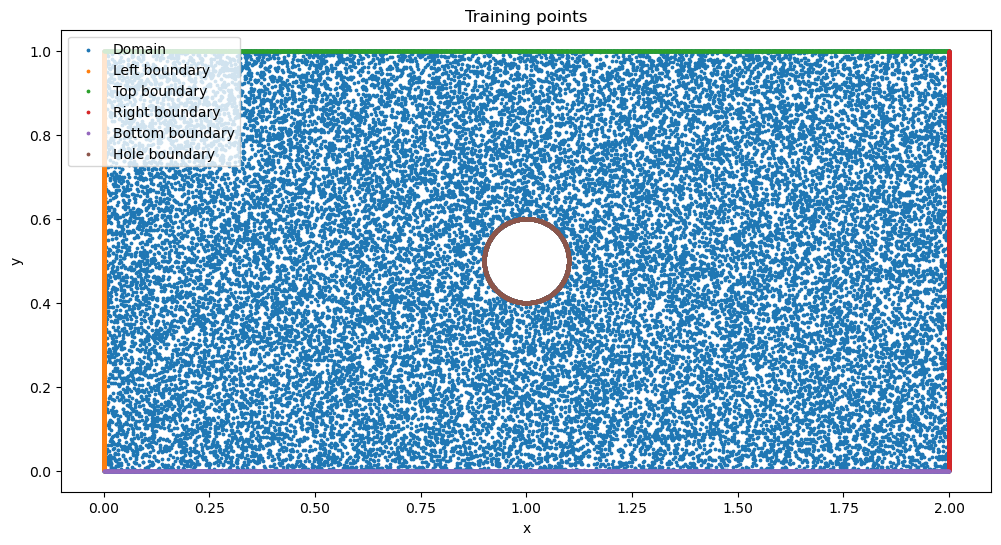

In [12]:
plt.figure(figsize=(12, 6))

plt.scatter(X, Y, label="Domain", s=3)
plt.scatter(X[mask_left], Y[mask_left], label="Left boundary", s=3)
plt.scatter(X[mask_top], Y[mask_top], label="Top boundary", s=3)
plt.scatter(X[mask_right], Y[mask_right], label="Right boundary", s=3)
plt.scatter(X[mask_down], Y[mask_down], label="Bottom boundary", s=3)
plt.scatter(X[mask_hole], Y[mask_hole], label="Hole boundary", s=3)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Training points")
plt.legend(loc="upper left")
plt.show()

In [13]:
model = DNN(layers).to(device)

In [14]:
pinn = PINN(model)
pinn.set_var(X, Y, masks, h, l, r, nu)

In [15]:
pinn.train(10000)

Epoch 0, Loss: 1.051900e+00
PDE: 1.068775e-01, BC: 9.450224e-01
Epoch 100, Loss: 1.663639e-01
PDE: 5.044542e-02, BC: 1.159185e-01
Epoch 200, Loss: 1.496204e-01
PDE: 4.533034e-02, BC: 1.042900e-01
Epoch 300, Loss: 1.338305e-01
PDE: 4.183208e-02, BC: 9.199840e-02
Epoch 400, Loss: 1.130664e-01
PDE: 3.790917e-02, BC: 7.515725e-02
Epoch 500, Loss: 1.002145e-01
PDE: 4.043027e-02, BC: 5.978426e-02
Epoch 600, Loss: 2.961829e-01
PDE: 1.697627e-01, BC: 1.264202e-01
Epoch 700, Loss: 7.036251e-02
PDE: 3.804841e-02, BC: 3.231410e-02
Epoch 800, Loss: 5.937496e-02
PDE: 3.365352e-02, BC: 2.572143e-02
Epoch 900, Loss: 5.494893e-02
PDE: 2.995826e-02, BC: 2.499066e-02
Epoch 1000, Loss: 1.069274e-01
PDE: 7.397927e-02, BC: 3.294817e-02
Epoch 1100, Loss: 5.040005e-02
PDE: 2.838607e-02, BC: 2.201398e-02
Epoch 1200, Loss: 4.920129e-02
PDE: 2.802170e-02, BC: 2.117958e-02
Epoch 1300, Loss: 5.357285e-02
PDE: 2.738234e-02, BC: 2.619051e-02
Epoch 1400, Loss: 4.784802e-02
PDE: 2.768923e-02, BC: 2.015879e-02
Epoch 1

In [16]:
pde, bc = pinn.loss_func()
loss = pde + bc
print(loss.item())

0.0004777680733241141


In [19]:
mesh_file = "meshes/hole_middle_r10_o1.inp"
csv_file = "meshes/hole_middle_r10_al.csv"

mesh = meshio.read(mesh_file)
df = pd.read_csv(csv_file, sep=',', skipinitialspace=True)

In [20]:
von_miss = df["Equivalent Stress"].values
nodes = mesh.points[:,:2]
a = len(nodes)
node_features = torch.tensor(von_miss[:a], dtype=torch.float).view(-1, 1)

print(len(nodes))

print(len(node_features[:a]))

5529
5529


In [21]:
edges = []
for cell in mesh.cells:
    if cell.type == "triangle":
        for element in cell.data:
            edges.append([element[0], element[1]])
            edges.append([element[1], element[0]])

            edges.append([element[1], element[2]])
            edges.append([element[2], element[1]])

            edges.append([element[2], element[0]])
            edges.append([element[0], element[2]])

edges = torch.tensor(edges, dtype=torch.long).t().contiguous()
pos = torch.tensor(nodes, dtype=torch.float)

data = Data(x=node_features, edge_index=edges, pos=pos)
print(data.x.shape)
print(data.pos.shape)

torch.Size([5529, 1])
torch.Size([5529, 2])


In [22]:
x = pos[:, 0:1].detach().cpu().numpy()
y = pos[:, 1:2].detach().cpu().numpy()

u, v, sxx, syy, sxy = pinn.predict(x, y)

E = 7e10  # Young's modulus (Pa)
sigma_0 = 50e6  # Applied stress (Pa)

U = sigma_0 / E

u = u*U
v = v*U
sxx = sxx*sigma_0
syy = syy*sigma_0
sxy = sxy*sigma_0
von_mises = np.sqrt(sxx**2 + syy**2 - sxx*syy + 3*sxy**2)
fem_von = node_features.detach().cpu().numpy()

In [23]:
l2_error = np.linalg.norm(von_mises - fem_von) / np.linalg.norm(fem_von, 2)
print(l2_error)

0.032535076
